---

## Grizzlies and Teddies and Black Bears, OH MY!

<img src="http://www.evanmarie.com/content/files/notebook_images/bears_banner.png" width=800>

In [ ]:
#@title Importing all the lovelies
%%capture
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
!pip install nbdev
from fastbook import *
from fastai.vision.widgets import *
import nbdev
from fastai.vision import *
from pathlib import Path
import PIL

# Scrapes images from DuckDuckGo
!pip install -q jmd_imagescraper
from jmd_imagescraper.core import * 
from jmd_imagescraper.imagecleaner import *

### ➢  Setting up the download file path

In [ ]:
animals=['grizzly bear','black bear', 'teddy bear']
path = Path().cwd()/"bears"   # assigns path to current working directory

### ➢ Downloading 400 images of each class for training and validation

In [ ]:
%%capture
duckduckgo_search(path,"teddy bear","teddy bear",max_results=400) # downloading 400 images of teddy bears and saving to "teddy bear" folder
duckduckgo_search(path,"black bear","black bear",max_results=400) # downloading 400 images of black bears and saving to "black bear" folder
duckduckgo_search(path,"grizzly bear","grizzly bear",max_results=400) # downloading 400 images of grizzly bears and saving to "grizzly bear" folder

In [11]:
all_images=get_image_files(path)
all_images

(#1200) [Path('/content/bears/grizzly bear/160_2ee96a97.jpg'),Path('/content/bears/grizzly bear/019_ca8d0347.jpg'),Path('/content/bears/grizzly bear/200_bc56adfc.jpg'),Path('/content/bears/grizzly bear/197_92bebefe.jpg'),Path('/content/bears/grizzly bear/125_c66f70c8.jpg'),Path('/content/bears/grizzly bear/231_c8245605.jpg'),Path('/content/bears/grizzly bear/327_90605d29.jpg'),Path('/content/bears/grizzly bear/089_45f935d5.jpg'),Path('/content/bears/grizzly bear/020_b0488df5.jpg'),Path('/content/bears/grizzly bear/359_5d4666cd.jpg')...]

### ➢ Removing any failed downloads

In [12]:
failed_images=verify_images(all_images)  # looks for files that arent images
failed_images

(#0) []

In [13]:
failed_images.map(Path.unlink);  # unlinks the failed files from the folder

In [14]:
bear_types = 'grizzly bear','black bear','teddy bear'
path = Path('bears')

### ➢ Creating dataoaders and designating the train-test splitting function

In [15]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

In [16]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [17]:
blocks=(ImageBlock, CategoryBlock)
get_items=get_image_files
splitter=RandomSplitter(valid_pct=0.2, seed=42)
get_y=parent_label
item_tfms=Resize(128)
dls = bears.dataloaders(path)

### ➢ A section of a batch of training photos with their labels

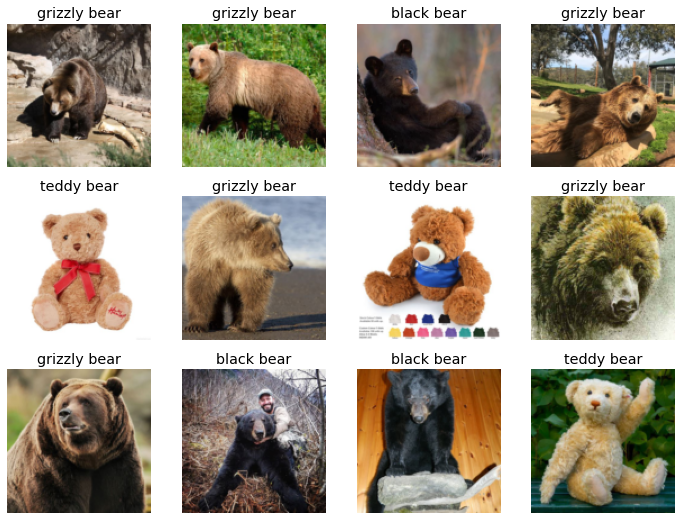

In [18]:
dls.valid.show_batch(max_n=12, nrows=3)

### Transforms / Resize Options / Data Augmentation

1.   `ResizeMethod.Squish`
2.   `ResizeMethod.Pad`
3.   `RandomResizedCrop`



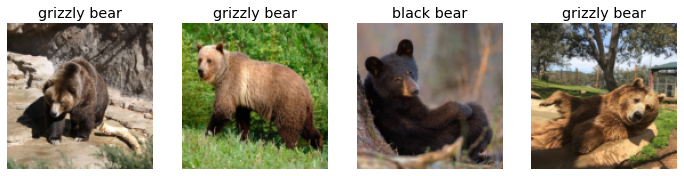

In [19]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

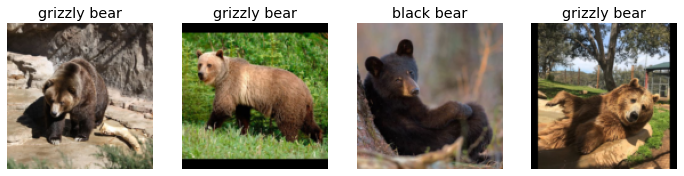

In [20]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

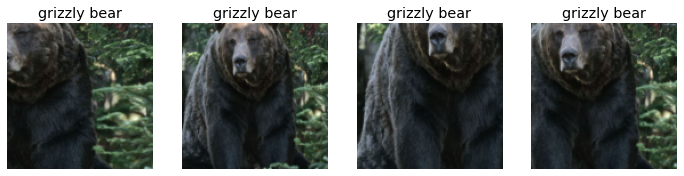

In [21]:
# Returns a different crop of each image each time
# This is an example of data augmentation, getting multiple
# files / images from the same source image

bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

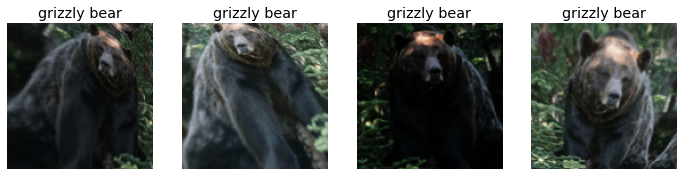

In [22]:
# Another example of data augmentation
# Good for when training for a larger number of epochs
# to eliminate overfitting and give more generalization

bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Training Model

<br>

These are the settings we will actually use with the model

In [23]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [28]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(7)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### ➢ Confusion Matrix
This shows where the model made incorrect predictions

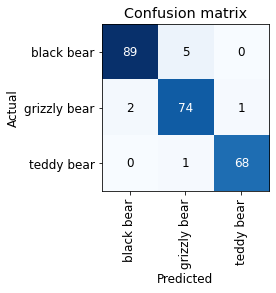

In [29]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### **`plot_top_losses()`**
Here we see places where the model incorrectly predicted, the resulting loss, and with what level of confidence it made each prediction.

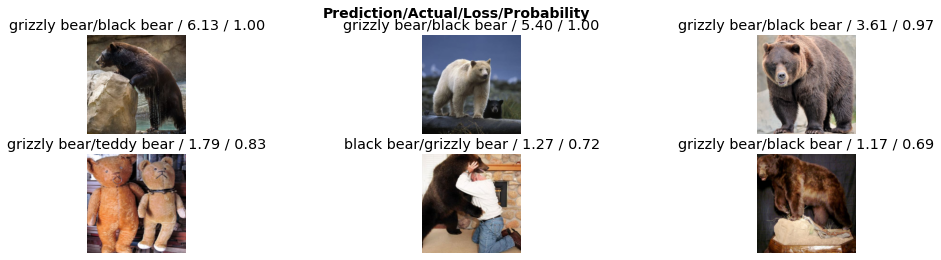

In [31]:
interp.plot_top_losses(6, nrows=2, figsize=(17,4))

### ➢ Clearning out the troublesome data

`ImageClassifierCleaner()` organizes the images by highest loss so that we can clean out the ones that are mislabeled. Here, you can go and check that the images in the training and in the validation set are all correctly categorized, change ones that are miscategorized, and delete ones that are just plain wrong.

In [32]:
cleaner = ImageClassifierCleaner(learn)
cleaner

### ➢ Removing any images marked for deletion

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [ ]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

### ➢ Exporting the model

In [ ]:
learn.export('bears.pk1')

### ➢ A look at predictions

black bear


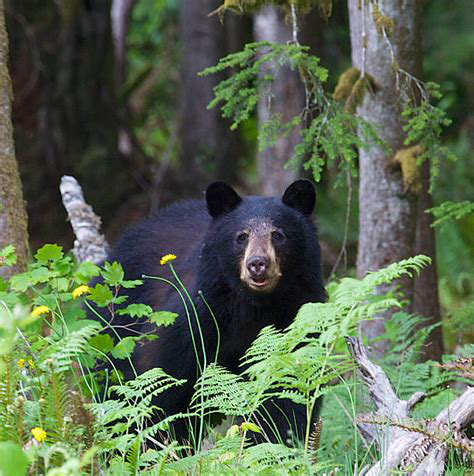

In [33]:
bear_01 = get_image_files(path)[888]
print(learn.predict(bear_01)[0])
img = PIL.Image.open(bear_01)
img

teddy bear


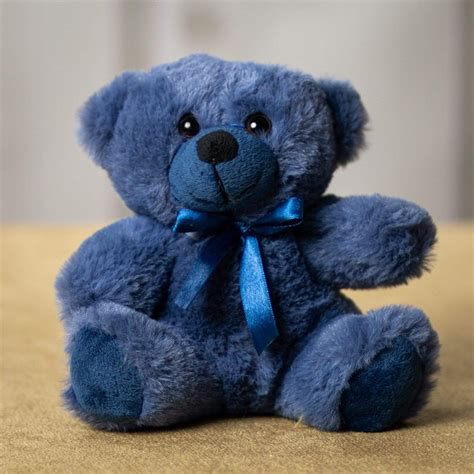

In [34]:
bear_02 = get_image_files(path)[777]
print(learn.predict(bear_02)[0])
img = PIL.Image.open(bear_02)
img

black bear


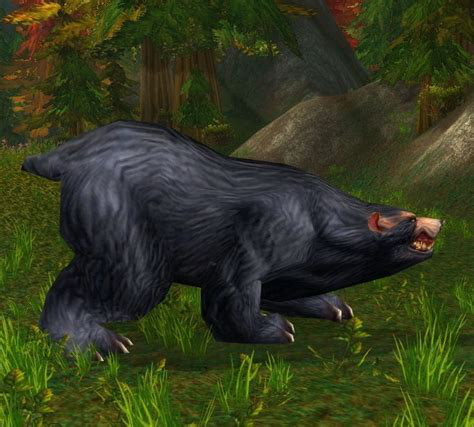

In [39]:
bear_03 = get_image_files(path)[1111]
print(learn.predict(bear_03)[0])
img = PIL.Image.open(bear_03)
img

grizzly bear


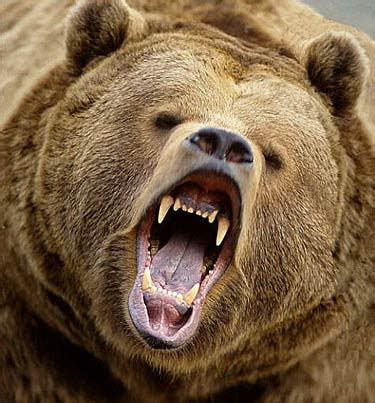

In [40]:
bear_04 = get_image_files(path)[222]
print(learn.predict(bear_04)[0])
img = PIL.Image.open(bear_04)
img